chisq=1.1500
p-value=0.2835
dof=1
expected_freq=[[3068.35688185  726.64311815]
 [ 250.64311815   59.35688185]]
训练集样本量: 2874 
测试集样本量: 1231
aic is 2539.65259738261,continuing!
aic is 2448.9722277457986,continuing!
aic is 2406.5983198124777,continuing!
aic is 2401.055907759619,continuing!
aic is 2397.941361738123,continuing!
forward selection over!
final formula is bad_ind ~ fico_score + ltv + age_oldest_tr + tot_derog + bankruptcy_ind 
fico_score 	 1.5423133089544319
tot_derog 	 1.347832436613074
age_oldest_tr 	 1.1399926313381807
rev_util 	 1.084380320084259
ltv 	 1.024624792276886
veh_mileage 	 1.0105135995489773
The accurancy is 0.82
threshold: 0.0, precision: 1.00, recall:0.81 ,Specificity:0.19 , f1_score:0.90
threshold: 0.1, precision: 0.31, recall:0.95 ,Specificity:0.24 , f1_score:0.47


c:\python36\install\lib\site-packages\ipykernel_launcher.py:120: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
c:\python36\install\lib\site-packages\ipykernel_launcher.py:121: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
c:\python36\install\lib\site-packages\ipykernel_launcher.py:122: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


threshold: 0.2, precision: 0.65, recall:0.90 ,Specificity:0.31 , f1_score:0.76
threshold: 0.30000000000000004, precision: 0.86, recall:0.86 ,Specificity:0.37 , f1_score:0.86
threshold: 0.4, precision: 0.94, recall:0.84 ,Specificity:0.43 , f1_score:0.89
threshold: 0.5, precision: 0.98, recall:0.83 ,Specificity:0.60 , f1_score:0.90
threshold: 0.6000000000000001, precision: 0.99, recall:0.82 ,Specificity:0.70 , f1_score:0.90
threshold: 0.7000000000000001, precision: 1.00, recall:0.82 ,Specificity:0.80 , f1_score:0.90
threshold: 0.8, precision: 1.00, recall:0.81 ,Specificity:0.50 , f1_score:0.90
threshold: 0.9, precision: 1.00, recall:0.81 ,Specificity:0.19 , f1_score:0.90
AUC = 0.7318


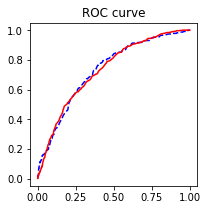

In [35]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

f=open('C:/计算机软件/Python_book/Python_book/8Logistic/accepts.csv')
accepts=pd.read_csv(f,skipinitialspace=True)
accepts=accepts.dropna(axis=0,how='any')
cross_table=pd.crosstab(accepts.bankruptcy_ind,accepts.bad_ind,margins=True)


#转化为列联表
def percConvert(ser):
    return ser/float(ser[-1])

cross_table.apply(percConvert,axis=1)

#使用卡方检验
print('''chisq=%6.4f
p-value=%6.4f
dof=%i
expected_freq=%s'''%stats.chi2_contingency(cross_table.iloc[:2,:2]))
#在Python中实现Logistic回归
train=accepts.sample(frac=0.7,random_state=1234).copy()
test=accepts[~accepts.index.isin(train.index)].copy()
print('训练集样本量: %i \n测试集样本量: %i'%(len(train),len(test)))

#1.单变量逻辑回归
lg=smf.glm('bad_ind~fico_score',data=train,family=sm.families.Binomial(sm.families.links.logit)).fit()
lg.summary()

#2.多变量逻辑回归
formula='''bad_ind~fico_score+bankruptcy_ind+tot_derog+age_oldest_tr
+rev_util+ltv+veh_mileage
'''
lg_m=smf.glm(formula=formula,data=train,family=sm.families.Binomial(sm.families.links.logit)).fit()
lg_m.summary().tables[1]

#向前法筛选变量
def forward_select(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float(2397.2), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response,' + '.join(selected + [candidate]))
            aic = smf.glm(
                formula=formula, data=data, 
                family=sm.families.Binomial(sm.families.links.logit)
            ).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        if current_score < best_new_score: 
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            print ('aic is {},continuing!'.format(best_new_score))
        else:        
            print ('forward selection over!')
            break
            
    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    model = smf.glm(
        formula=formula, data=data, 
        family=sm.families.Binomial(sm.families.links.logit)
    ).fit()
    return(model)

#只有连续变量可以进行变量筛选，分类变量需要进行WOE转换才可以进行变量筛选
candidates = ['bad_ind','fico_score','bankruptcy_ind','tot_derog','age_oldest_tr'
,'rev_util','ltv','veh_mileage']
data_for_select = train[candidates]

lg_m1 = forward_select(data=data_for_select, response='bad_ind')
lg_m1.summary().tables[1]

#方差膨胀因子
def vif(df, col_i):
    from statsmodels.formula.api import ols
    
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)


# In[18]:
exog = train[candidates].drop(['bad_ind','bankruptcy_ind'], axis=1)

for i in exog.columns:
    print(i, '\t', vif(df=exog, col_i=i))
    
#输出违约概率得分
train['proba'] = lg.predict(train)
test['proba'] = lg.predict(test)
test['proba'].head(10)
test['prediction'] = (test['proba'] > 0.5).astype('int')
acc = sum(test['prediction'] == test['bad_ind']) /np.float(len(test))
print('The accurancy is %.2f' %acc)


# 混淆矩阵
pd.crosstab(test.bad_ind, test.prediction, margins=True)

#不同阀值模型下的表现
for i in np.arange(0, 1, 0.1):
    prediction = (test['proba'] > i).astype('int')
    confusion_matrix = pd.crosstab(prediction,test.bad_ind,
                                   margins = True)
    precision = confusion_matrix.ix[0, 0] /confusion_matrix.ix['All', 0]
    recall = confusion_matrix.ix[0, 0] / confusion_matrix.ix[0, 'All']
    Specificity = confusion_matrix.ix[1, 1] /confusion_matrix.ix[1,'All']
    f1_score = 2 * (precision * recall) / (precision + recall)
    print('threshold: %s, precision: %.2f, recall:%.2f ,Specificity:%.2f , f1_score:%.2f'%(i, precision, recall, Specificity,f1_score))
    
    
    
    
    

#roc曲线绘制
fpr_test, tpr_test, th_test = metrics.roc_curve(test.bad_ind, test.proba)
fpr_train, tpr_train, th_train = metrics.roc_curve(train.bad_ind, train.proba)

plt.figure(figsize=[3, 3])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')


#AUC定量比较
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))